In [1]:
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pl.read_csv("./../data/cleaned_flight_data.csv",try_parse_dates=True)

In [3]:
sns.set_theme(style="whitegrid")

### 1. AIRLINE PERFORMANCE ANALYSIS

In [4]:
kpi_basic = df.select([
    pl.col("AIRLINE_NAME").n_unique().alias("Unique Airlines"),
    pl.col("ORIGIN_CODE").n_unique().alias("Unique Origin Airports"),
    pl.col("DEST_CODE").n_unique().alias("Unique Destination Airports"),
    pl.col("FLIGHT_NUM").count().alias("Total Flights")
])
kpi_basic

Unique Airlines,Unique Origin Airports,Unique Destination Airports,Total Flights
u32,u32,u32,u32
14,628,629,5819079


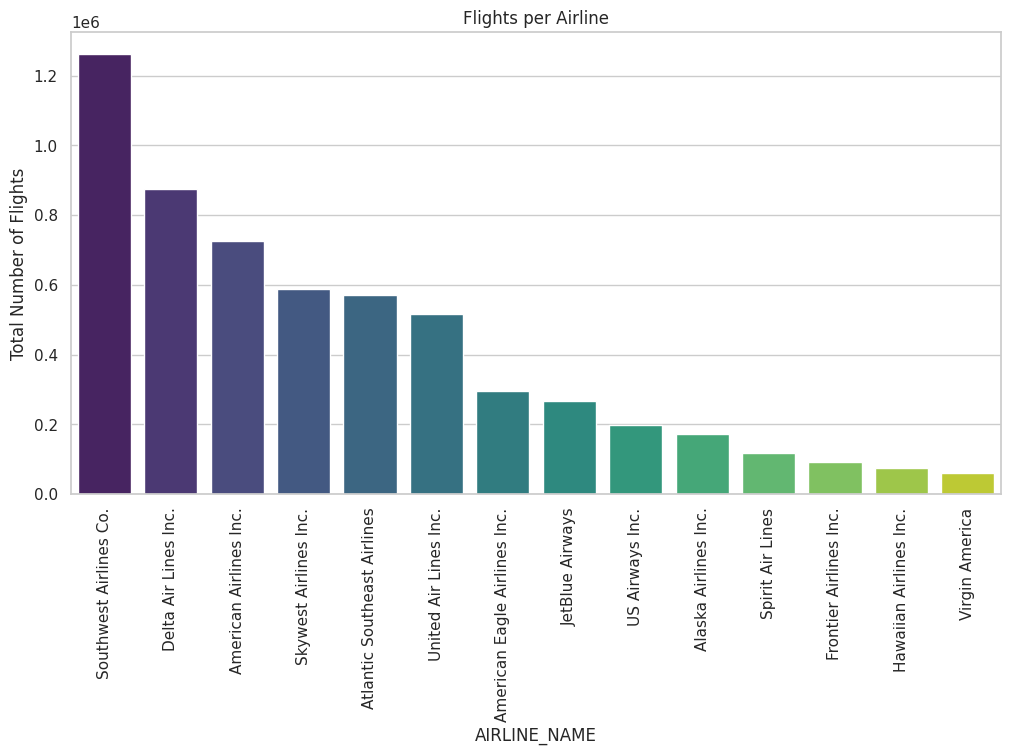

In [5]:
# -- flights per airline -- 
flights_per_airline = (
    df.group_by("AIRLINE_NAME")
    .agg(pl.count("FLIGHT_NUM").alias("Total Number of Flights"))
    .sort("Total Number of Flights", descending=True)
)

plt.figure(figsize=(12,6))
sns.barplot(data=flights_per_airline.to_pandas(), 
            x="AIRLINE_NAME", y="Total Number of Flights", hue = "AIRLINE_NAME", palette="viridis")
plt.xticks(rotation= 90)
plt.title("Flights per Airline")
plt.show()

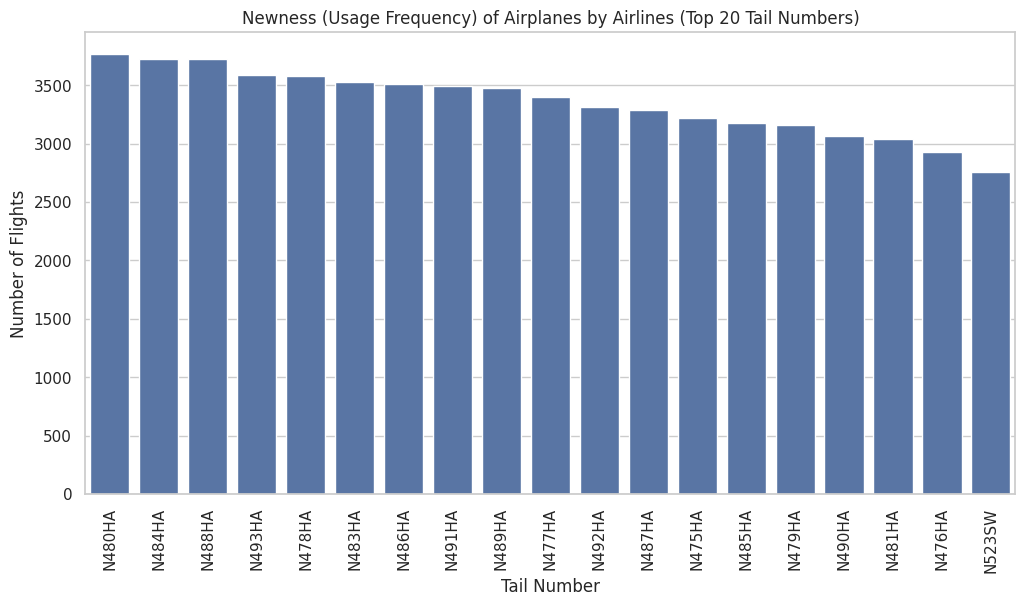

In [6]:
# -- Newness of airplanes owned by airlines -- 

plt.figure(figsize=(12,6))
tail_counts = df.group_by("TAIL_NUM").agg(pl.count("FLIGHT_NUM").alias("Flights")).sort("Flights", descending=True).head(20)
sns.barplot(data=tail_counts.to_pandas(), x="TAIL_NUM", y="Flights")
plt.xticks(rotation=90)
plt.title("Newness (Usage Frequency) of Airplanes by Airlines (Top 20 Tail Numbers)")
plt.ylabel("Number of Flights")
plt.xlabel("Tail Number")
plt.show()

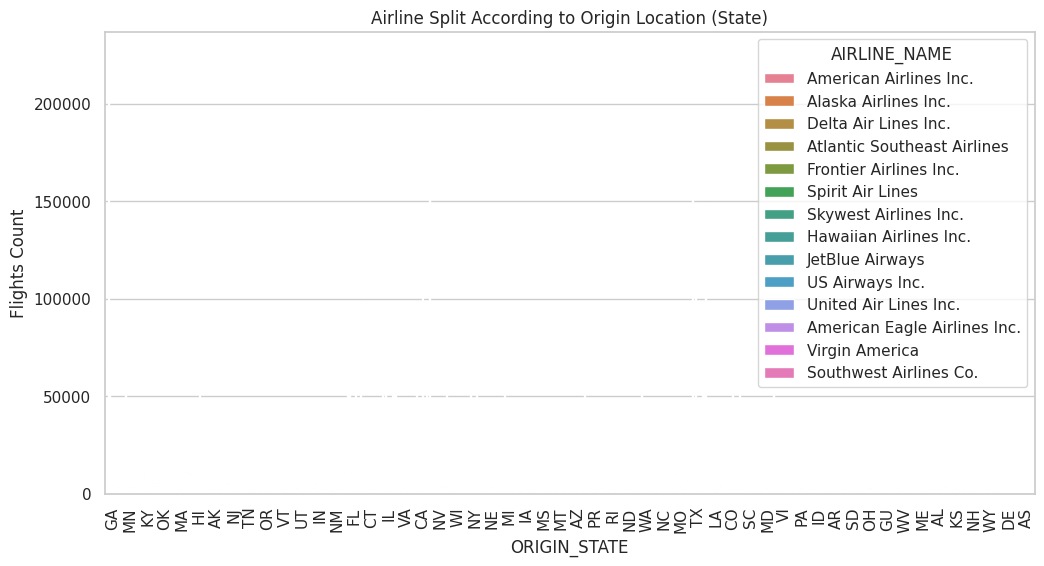

In [7]:
# -- Airline split according to location (Origin State) 

plt.figure(figsize=(12,6))
state_airline = df.group_by(["ORIGIN_STATE", "AIRLINE_NAME"]).agg(pl.count("FLIGHT_NUM").alias("Flights"))
sns.barplot(data=state_airline.to_pandas(), x="ORIGIN_STATE", y="Flights", hue="AIRLINE_NAME")
plt.xticks(rotation=90)
plt.title("Airline Split According to Origin Location (State)")
plt.ylabel("Flights Count")
plt.show()


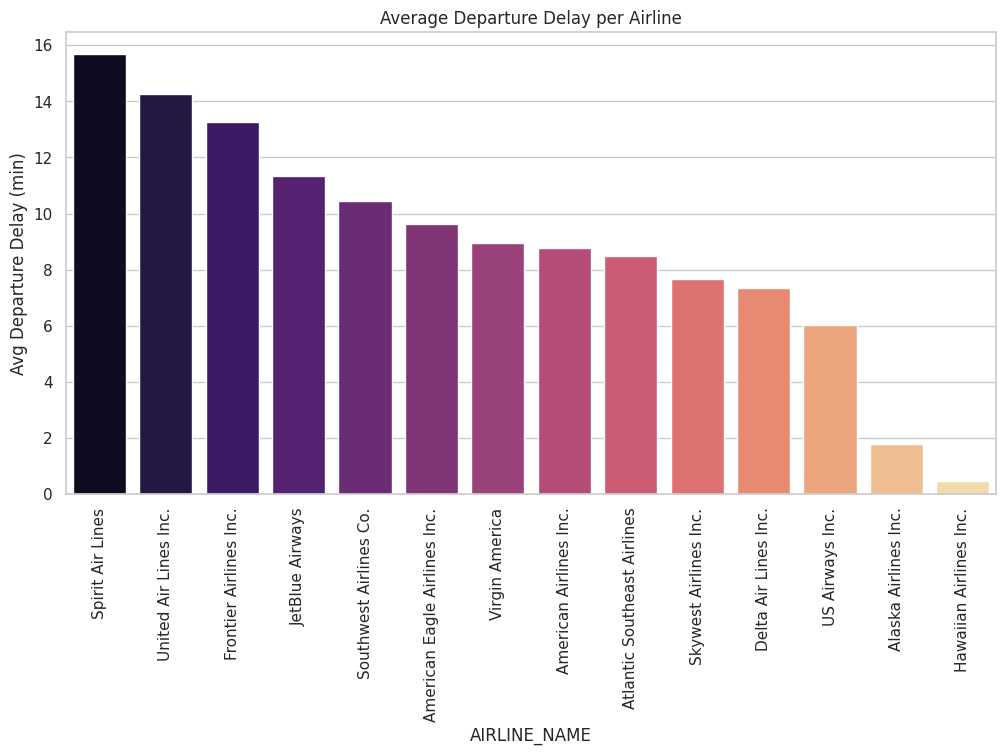

In [8]:
# -- Average Departure Delay by Airline --
avg_dep_delay = (
    df.group_by("AIRLINE_NAME").agg(pl.col("DEP_DELAY").mean().alias("Avg Departure Delay (min)")).sort("Avg Departure Delay (min)", descending=True)
)

plt.figure(figsize=(12,6))
sns.barplot(data=avg_dep_delay.to_pandas(), 
            x="AIRLINE_NAME", y="Avg Departure Delay (min)", hue = "AIRLINE_NAME",  palette="magma")
plt.xticks(rotation=90)
plt.title("Average Departure Delay per Airline")
plt.show()

In [9]:
#on-time % for different airlines

on_time_airline = (
    df.with_columns((pl.col("ARR_DELAY") <= 0).alias("OnTime"))
    .group_by("AIRLINE_NAME")
    .agg([
        pl.count("FLIGHT_NUM").alias("Total Flights"),
        pl.col("OnTime").sum().alias("OnTime Flights")
    ])
    .with_columns((pl.col("OnTime Flights") / pl.col("Total Flights") * 100).alias("OnTime %"))
    .sort("OnTime %", descending=True)
)

on_time_airline.head()


AIRLINE_NAME,Total Flights,OnTime Flights,OnTime %
str,u32,u32,f64
"""Delta Air Lines Inc.""",875881,625041,71.361406
"""Alaska Airlines Inc.""",172521,115568,66.987787
"""American Airlines Inc.""",725984,473793,65.262182
"""American Eagle Airlines Inc.""",294632,191127,64.869736
"""United Air Lines Inc.""",515723,329496,63.890112


### 2. AIRPORT AND ROUTE ANALYSIS

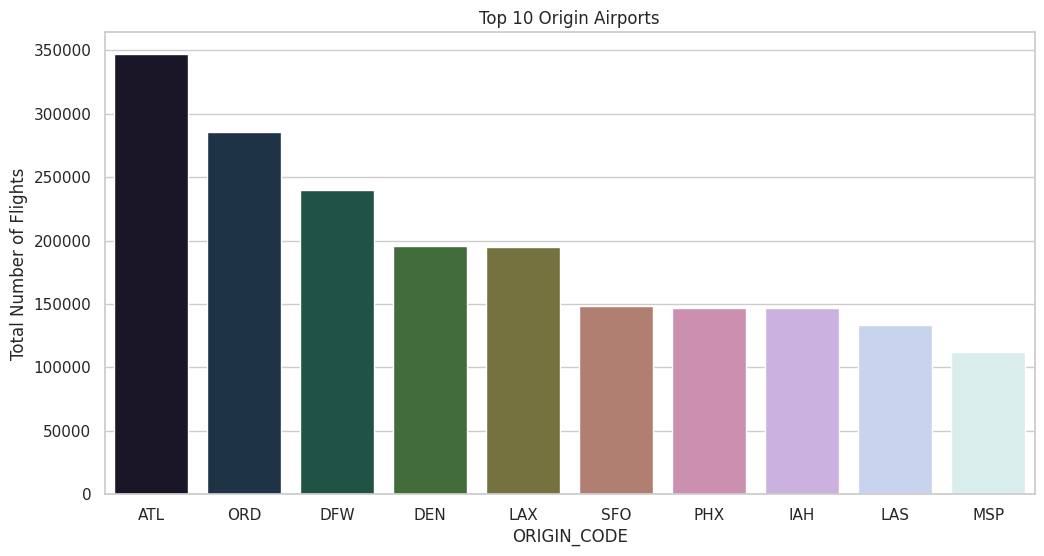

In [10]:
# -- Top 10 Busiest Origin Airports --
top_origin = (
    df.group_by("ORIGIN_CODE")
    .agg(pl.count("FLIGHT_NUM").alias("Total Number of Flights"))
    .sort("Total Number of Flights", descending=True)
    .head(10)
)

plt.figure(figsize=(12,6))
sns.barplot(data=top_origin.to_pandas(), x="ORIGIN_CODE", y="Total Number of Flights",hue = "ORIGIN_CODE", palette="cubehelix")
plt.title("Top 10 Origin Airports")
plt.show()



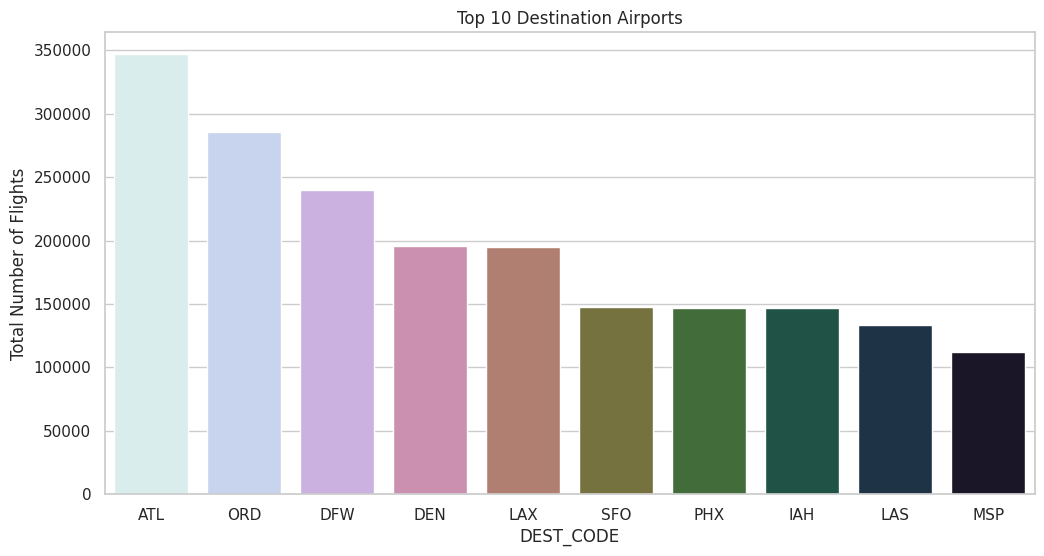

In [11]:
# -- Top 10 Busiest Destination Airports -- 
top_dest = (
    df.group_by("DEST_CODE")
    .agg(pl.count("FLIGHT_NUM").alias("Total Number of Flights"))
    .sort("Total Number of Flights", descending=True)
    .head(10)
) 

plt.figure(figsize=(12,6))
sns.barplot(data=top_dest.to_pandas(), x="DEST_CODE", y="Total Number of Flights",hue = "DEST_CODE", palette="cubehelix_r")
plt.title("Top 10 Destination Airports")
plt.show()


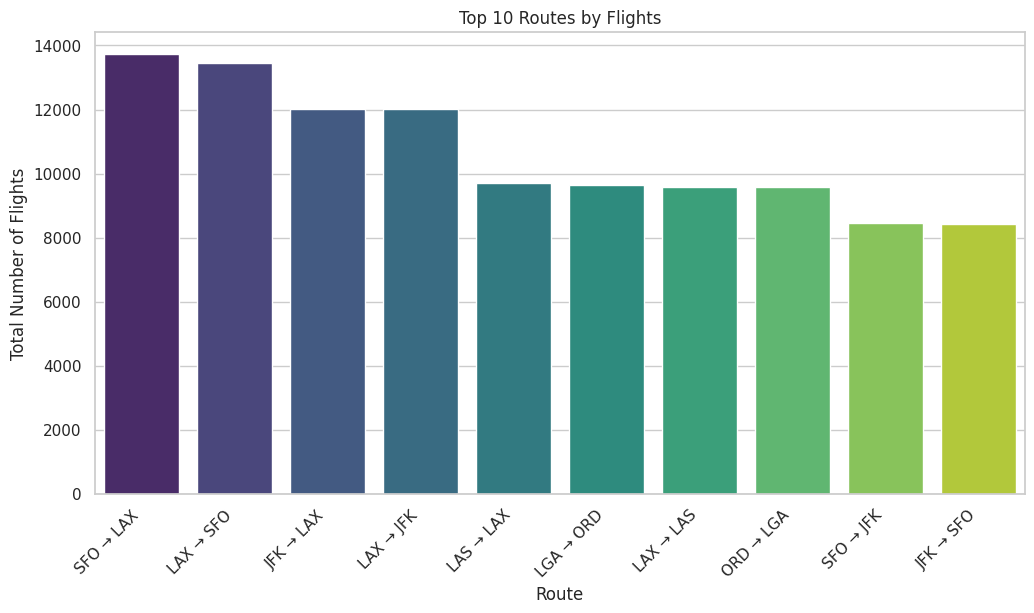

In [12]:
# -- Most Common Routes--
routes = (
    df.with_columns((pl.col("ORIGIN_CODE") + " → " + pl.col("DEST_CODE")).alias("Route"))
    .group_by("Route")
    .agg(pl.count("FLIGHT_NUM").alias("Total Number of Flights"))
    .sort("Total Number of Flights", descending=True)
    .head(10)
)

plt.figure(figsize=(12,6))
sns.barplot(data=routes.to_pandas(), x="Route", y="Total Number of Flights",hue = "Route",  palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Routes by Flights")
plt.show()


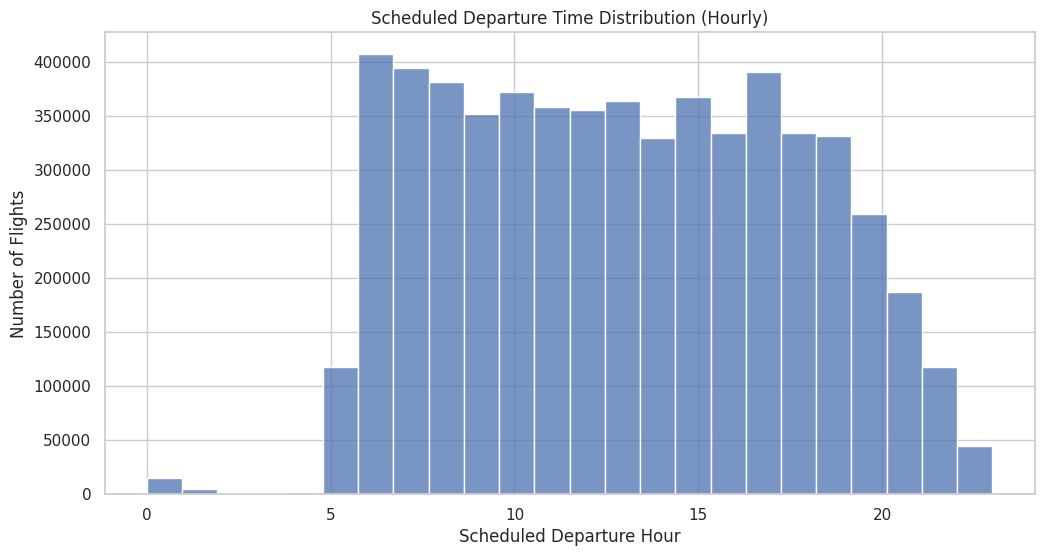

In [13]:
# -- Scheduled departure time bias by airport -- 
plt.figure(figsize=(12,6))
sns.histplot(data=df.to_pandas(), x=df.to_pandas()["SCHED_DEP_TIME"].dt.hour, bins=24, kde=False)
plt.title("Scheduled Departure Time Distribution (Hourly)")
plt.xlabel("Scheduled Departure Hour")
plt.ylabel("Number of Flights")
plt.show()


In [14]:
# -- Taxi Times by Airport -- 
taxi_times = (
    df.group_by("ORIGIN_CODE")
    .agg([
        pl.col("TAXI_OUT").mean().alias("Avg Taxi Out (min)"),
        pl.col("TAXI_IN").mean().alias("Avg Taxi In (min)")
    ])
    .sort("Avg Taxi Out (min)", descending=True)
    .head(10)
)

taxi_times


ORIGIN_CODE,Avg Taxi Out (min),Avg Taxi In (min)
str,f64,f64
"""JFK""",27.009783,7.191489
"""LGA""",26.72137,7.818918
"""12953""",26.660012,7.849581
"""12478""",23.677466,7.23368
"""13502""",23.666667,7.0
"""ITH""",22.533333,7.733333
"""PHL""",21.709366,7.960159
"""ISN""",20.996419,7.888933
"""12389""",20.509091,7.872727


/tmp/ipykernel_313584/4246206124.py:11: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  df.filter(pl.col("ORIGIN_CODE").is_in(top20))


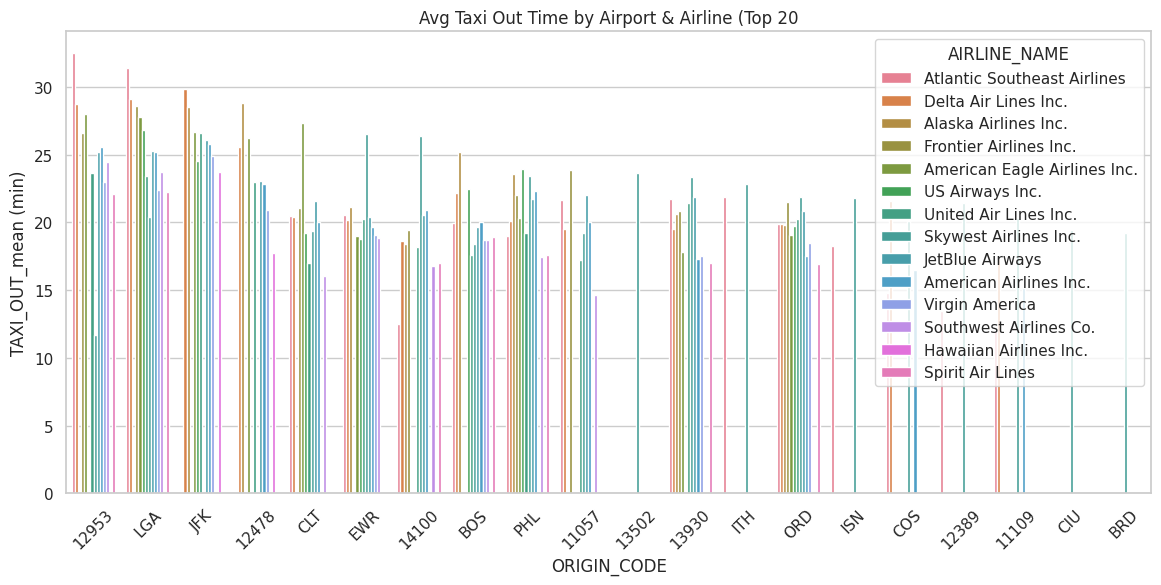

In [15]:
# -- Avg Taxi Out by Airport & Airline for top 20 airports
top20 = (
    df.group_by("ORIGIN_CODE")
      .agg(pl.col("TAXI_OUT").mean().alias("AVG_TAXI_OUT"))
      .sort("AVG_TAXI_OUT", descending=True)
      .head(20)
      .get_column("ORIGIN_CODE")
)

df_agg = (
    df.filter(pl.col("ORIGIN_CODE").is_in(top20))
      .group_by(["ORIGIN_CODE", "AIRLINE_NAME"])
      .agg(pl.col("TAXI_OUT").mean().alias("TAXI_OUT_mean (min)"))
      .sort(["TAXI_OUT_mean (min)"], descending=True)
)

pdf = df_agg.to_pandas()

plt.figure(figsize=(14,6))
sns.barplot(data=pdf,  x="ORIGIN_CODE", y="TAXI_OUT_mean (min)", hue="AIRLINE_NAME")
plt.xticks(rotation=45)
plt.title("Avg Taxi Out Time by Airport & Airline (Top 20")
plt.show()

/tmp/ipykernel_313584/2058275645.py:13: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  df.filter(pl.col("DEST_CODE").is_in(top20_dest))


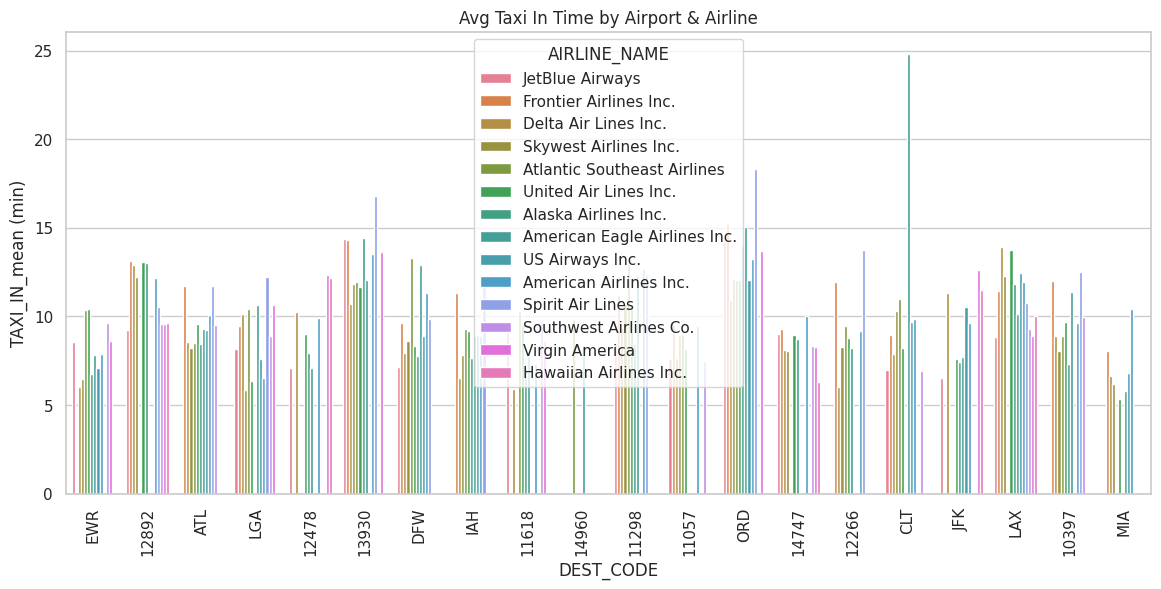

In [16]:
# -- Avg Taxi in time by airport and airline

top20_dest = (
    df.group_by("DEST_CODE")
      .agg(pl.col("TAXI_IN").mean().alias("AVG_TAXI_IN"))
      .sort("AVG_TAXI_IN", descending=True)
      .head(20)
      .get_column("DEST_CODE")
)

# Aggregate by DEST_CODE and AIRLINE_NAME for those top destinations
df_agg_in = (
    df.filter(pl.col("DEST_CODE").is_in(top20_dest))
      .group_by(["DEST_CODE", "AIRLINE_NAME"])
      .agg(pl.col("TAXI_IN").mean().alias("TAXI_IN_mean (min)"))
)

# Convert small aggregated result to pandas
pdf_in = df_agg_in.to_pandas()

plt.figure(figsize=(14,6))
sns.barplot(data=pdf_in, x="DEST_CODE", y="TAXI_IN_mean (min)", hue="AIRLINE_NAME")
plt.xticks(rotation=90)
plt.title("Avg Taxi In Time by Airport & Airline")
plt.show()


/tmp/ipykernel_313584/2478129016.py:28: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  df_with_dur.filter(pl.col("ORIGIN_CODE").is_in(top20))


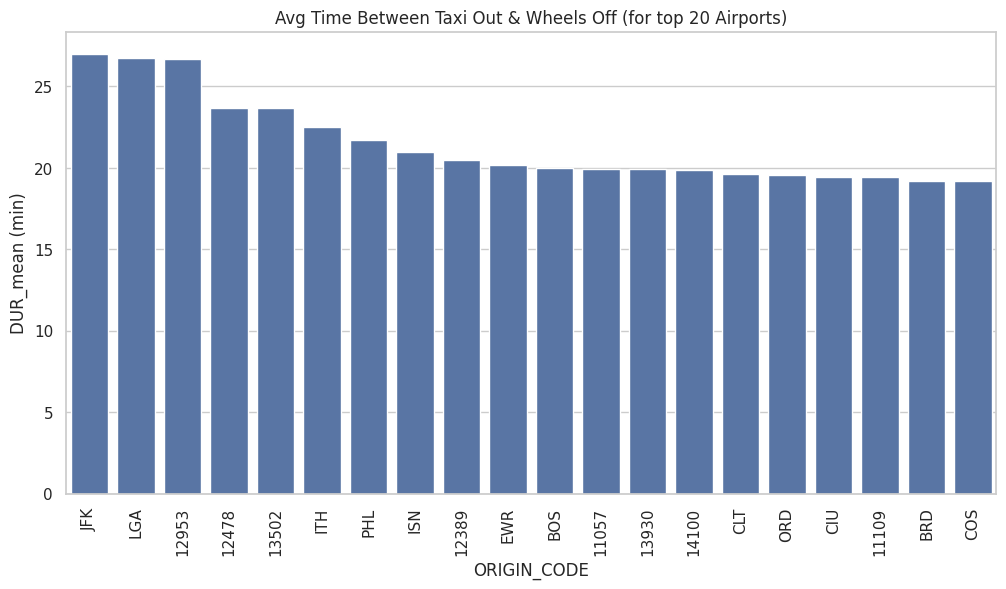

In [17]:
# -- Avg Time from pushback to actual takeoff
def hhmm_to_minutes(expr):
    hh = (expr // 100)
    mm = (expr % 100)
    return (hh * 60 + mm)

df_with_dur = df.with_columns([
    hhmm_to_minutes(pl.col("WHEELS_OFF")).alias("WO_min"),
    hhmm_to_minutes(pl.col("DEP_TIME")).alias("DEP_min"),
]).with_columns(
    (pl.col("WO_min") - pl.col("DEP_min")).alias("PUSHBACK_TO_WHEELS_OFF")
).with_columns(
    pl.when(pl.col("PUSHBACK_TO_WHEELS_OFF") < 0)
      .then(pl.col("PUSHBACK_TO_WHEELS_OFF") + 24*60)
      .otherwise(pl.col("PUSHBACK_TO_WHEELS_OFF"))
      .alias("PUSHBACK_TO_WHEELS_OFF")
)

top20 = (
    df_with_dur.group_by("ORIGIN_CODE")
      .agg(pl.col("PUSHBACK_TO_WHEELS_OFF").mean().alias("AVG_DUR"))
      .sort("AVG_DUR", descending=True)
      .head(20)
      .get_column("ORIGIN_CODE")
)

df_agg = (
    df_with_dur.filter(pl.col("ORIGIN_CODE").is_in(top20))
      .group_by("ORIGIN_CODE")
      .agg(pl.col("PUSHBACK_TO_WHEELS_OFF").mean().alias("DUR_mean (min)"))
      .sort("DUR_mean (min)", descending=True)
)

pdf = df_agg.to_pandas()

plt.figure(figsize=(12,6))
sns.barplot(data=pdf, x="ORIGIN_CODE", y="DUR_mean (min)")
plt.xticks(rotation=90)
plt.title("Avg Time Between Taxi Out & Wheels Off (for top 20 Airports)")
plt.show()


/tmp/ipykernel_313584/3873049585.py:28: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  df_with_dur.filter(pl.col("DEST_CODE").is_in(top20_dest))


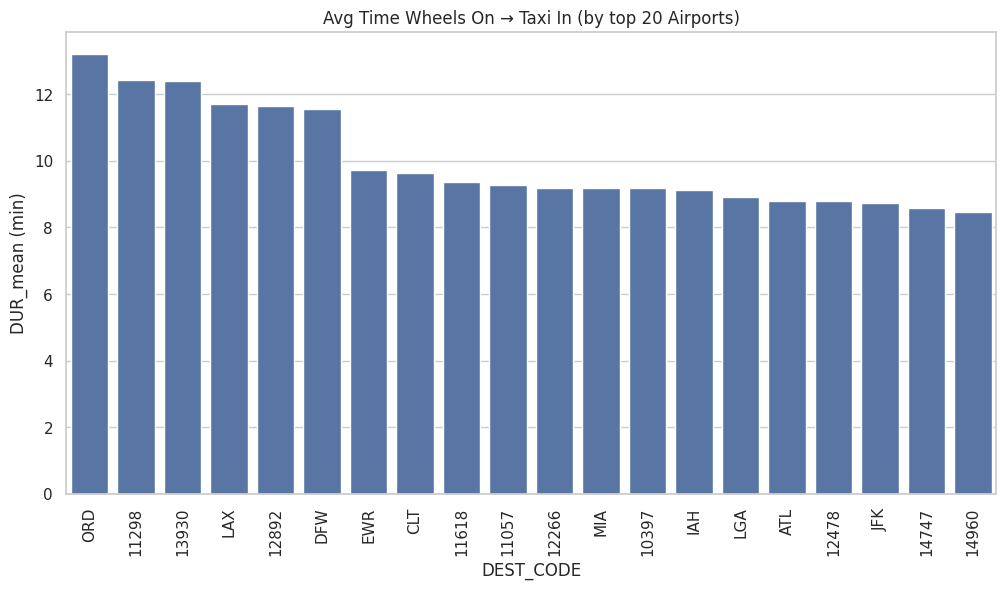

In [18]:
# -- Avg Time from landing to gate for top 20 Airports
def hhmm_to_minutes(expr):
    hh = (expr // 100)
    mm = (expr % 100)
    return (hh * 60 + mm)

df_with_dur = df.with_columns([
    hhmm_to_minutes(pl.col("WHEELS_ON")).alias("WO_min"),
    hhmm_to_minutes(pl.col("ARR_TIME")).alias("ARR_min"),
]).with_columns(
    (pl.col("ARR_min") - pl.col("WO_min")).alias("WHEELSON_TO_GATE")
).with_columns(
    pl.when(pl.col("WHEELSON_TO_GATE") < 0)
      .then(pl.col("WHEELSON_TO_GATE") + 24*60)
      .otherwise(pl.col("WHEELSON_TO_GATE"))
      .alias("WHEELSON_TO_GATE")
)

top20_dest = (
    df_with_dur.group_by("DEST_CODE")
      .agg(pl.col("WHEELSON_TO_GATE").mean().alias("AVG_DUR"))
      .sort("AVG_DUR", descending=True)
      .head(20)
      .get_column("DEST_CODE")
)

df_agg = (
    df_with_dur.filter(pl.col("DEST_CODE").is_in(top20_dest))
      .group_by("DEST_CODE")
      .agg(pl.col("WHEELSON_TO_GATE").mean().alias("DUR_mean (min)"))
      .sort("DUR_mean (min)", descending=True)
)

pdf = df_agg.to_pandas()

plt.figure(figsize=(12,6))
sns.barplot(data=pdf, x="DEST_CODE", y="DUR_mean (min)")
plt.xticks(rotation=90)
plt.title("Avg Time Wheels On → Taxi In (by top 20 Airports)")
plt.show()


### 3. SEASONS AND TIME ANALYSIS

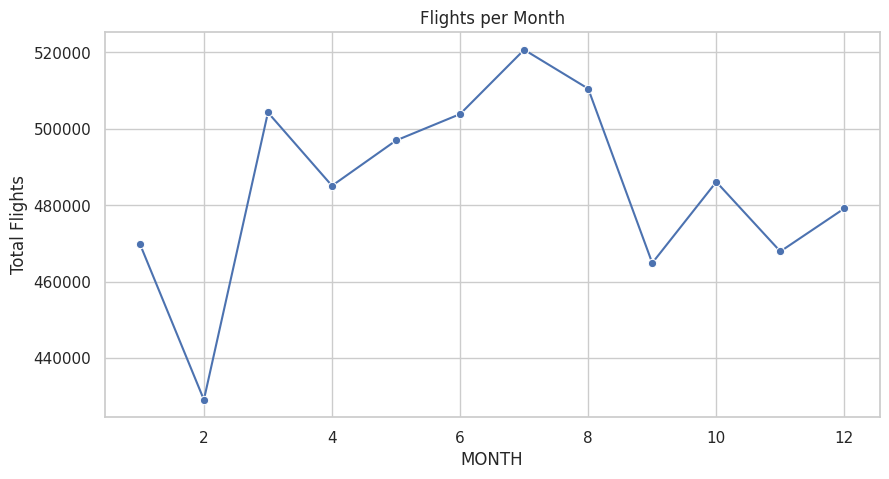

In [19]:
# flights per month 

flights_per_month = (
    df.group_by("MONTH")
    .agg(pl.count("FLIGHT_NUM").alias("Total Flights"))
    .sort("MONTH")
)

plt.figure(figsize=(10,5))
sns.lineplot(data=flights_per_month.to_pandas(), x="MONTH", y="Total Flights", marker="o")
plt.title("Flights per Month")
plt.show()


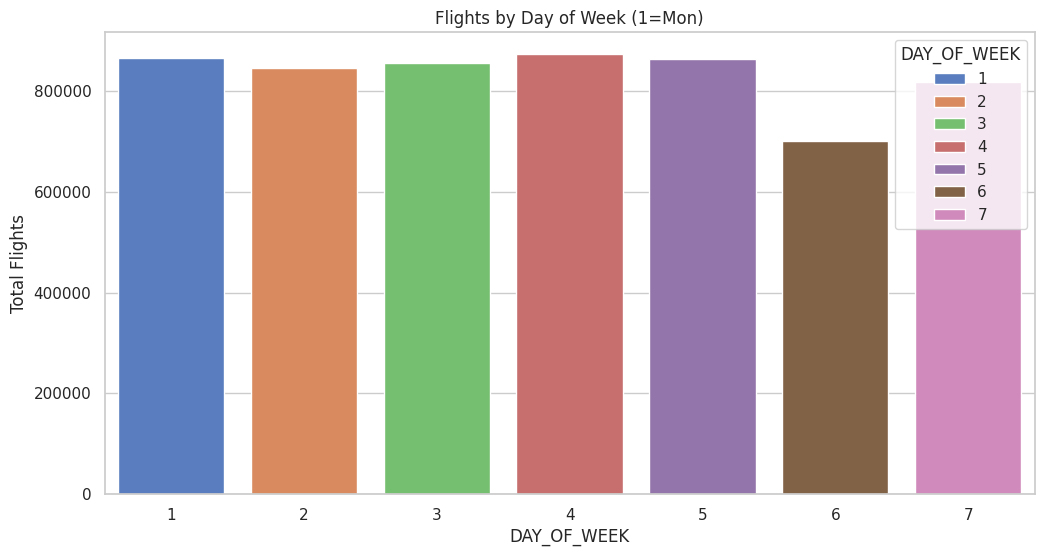

In [20]:
plt.figure(figsize=(12,6))
sns.countplot(data=df.to_pandas(), x="DAY_OF_WEEK",hue ="DAY_OF_WEEK",  palette="muted")
plt.title("Flights by Day of Week (1=Mon)")
plt.ylabel("Total Flights")
plt.show()

### 4. DELAYS AND CANCELLATIONS

In [21]:
#-- Overall on-time performance
on_time_perf = (
    df.with_columns((pl.col("ARR_DELAY") <= 0).alias("OnTime"))
    .select([
        pl.count("FLIGHT_NUM").alias("Total Flights"),
        pl.col("OnTime").sum().alias("OnTime Flights")
    ])
    .with_columns((pl.col("OnTime Flights") / pl.col("Total Flights") * 100).alias("OnTime %"))
)

on_time_perf

Total Flights,OnTime Flights,OnTime %
u32,u32,f64
5819079,3732183,64.137005


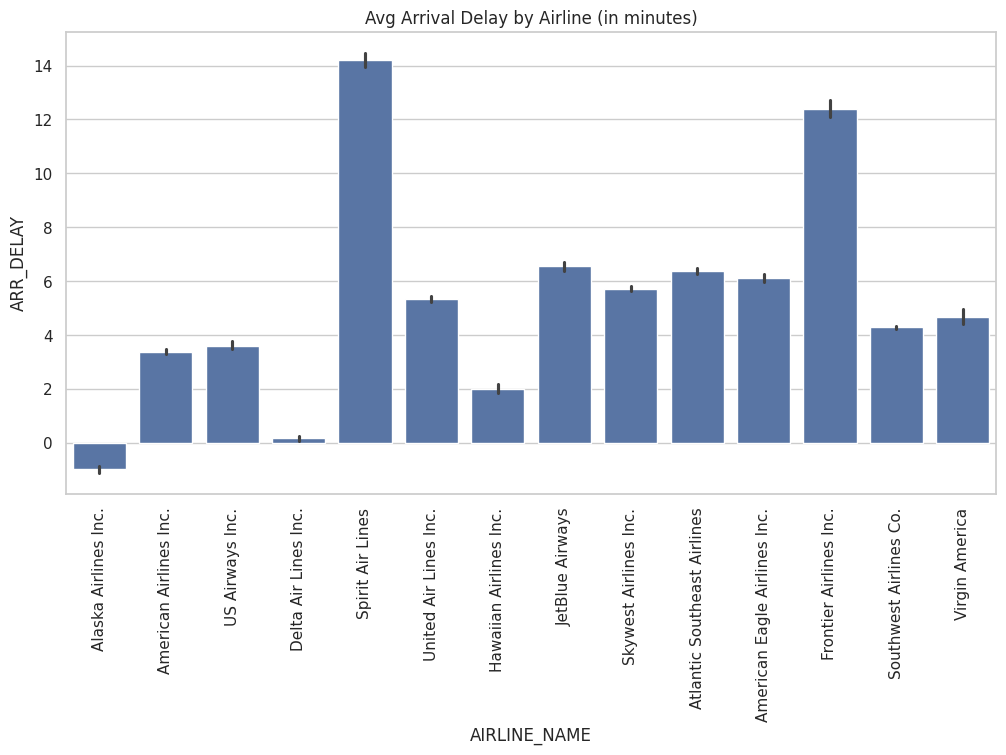

In [22]:
# -- Avg Arrival Delay by Airline
plt.figure(figsize=(12,6))
sns.barplot(data=df.to_pandas(), x="AIRLINE_NAME", y="ARR_DELAY", estimator="mean")
plt.xticks(rotation=90)
plt.title("Avg Arrival Delay by Airline (in minutes)")
plt.show()


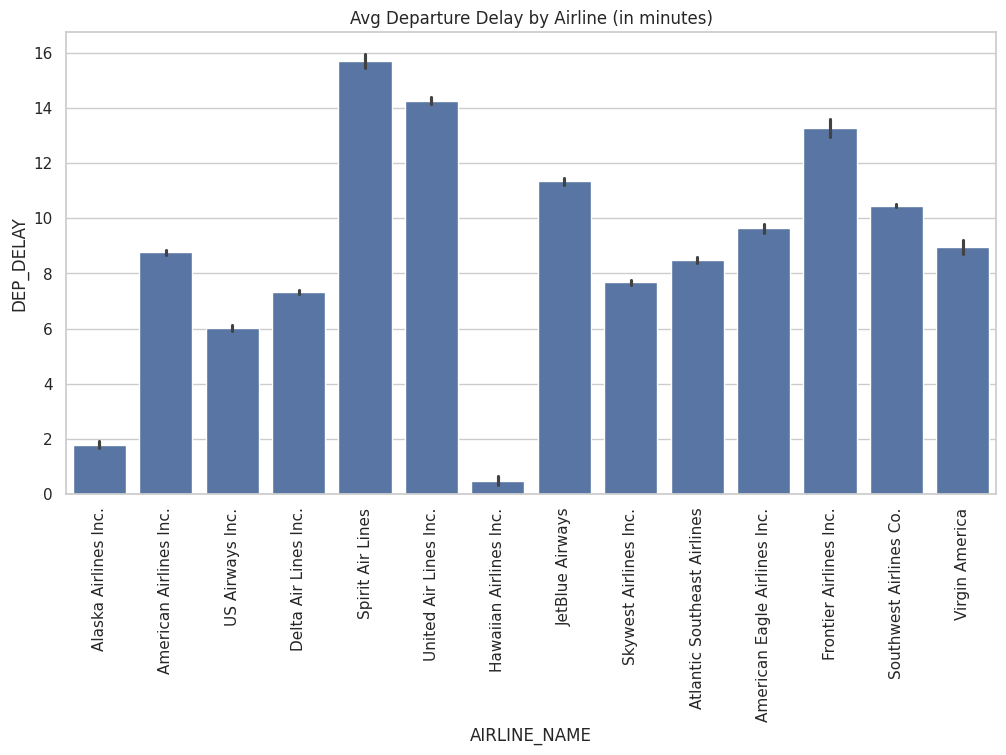

In [23]:
# -- Avg Departure Delay per Airline
plt.figure(figsize=(12,6))
sns.barplot(data=df.to_pandas(), x="AIRLINE_NAME", y="DEP_DELAY", estimator="mean")
plt.xticks(rotation=90)
plt.title("Avg Departure Delay by Airline (in minutes)")
plt.show()


/tmp/ipykernel_313584/1450974013.py:14: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  df_agg.filter(pl.col("ORIGIN_CODE").is_in(top20))


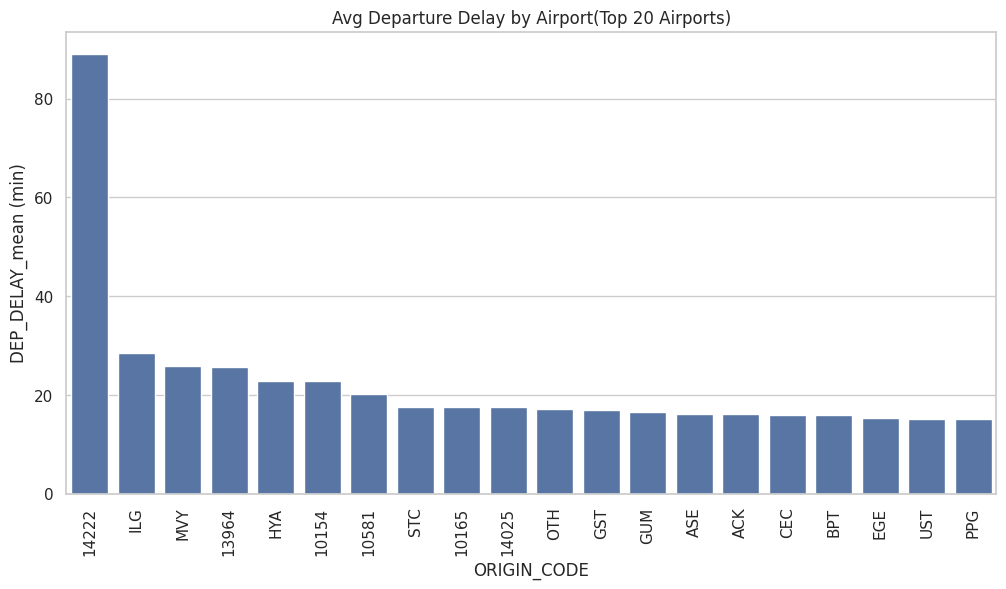

In [24]:
# -- Avg Departure Delay by Airport
df_agg = (
    df.group_by("ORIGIN_CODE")
      .agg(pl.col("DEP_DELAY").mean().alias("DEP_DELAY_mean (min)"))
)

top20 = (
    df_agg.sort("DEP_DELAY_mean (min)", descending=True)
          .head(20)
          .get_column("ORIGIN_CODE")
)

pdf = (
    df_agg.filter(pl.col("ORIGIN_CODE").is_in(top20))
          .sort("DEP_DELAY_mean (min)", descending=True)
          .to_pandas()
)

plt.figure(figsize=(12,6))
sns.barplot(data=pdf, x="ORIGIN_CODE", y="DEP_DELAY_mean (min)")
plt.xticks(rotation=90)
plt.title("Avg Departure Delay by Airport(Top 20 Airports)")
plt.show()


/tmp/ipykernel_313584/3387811828.py:16: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  df_agg.filter(pl.col("DEST_CODE").is_in(top20))


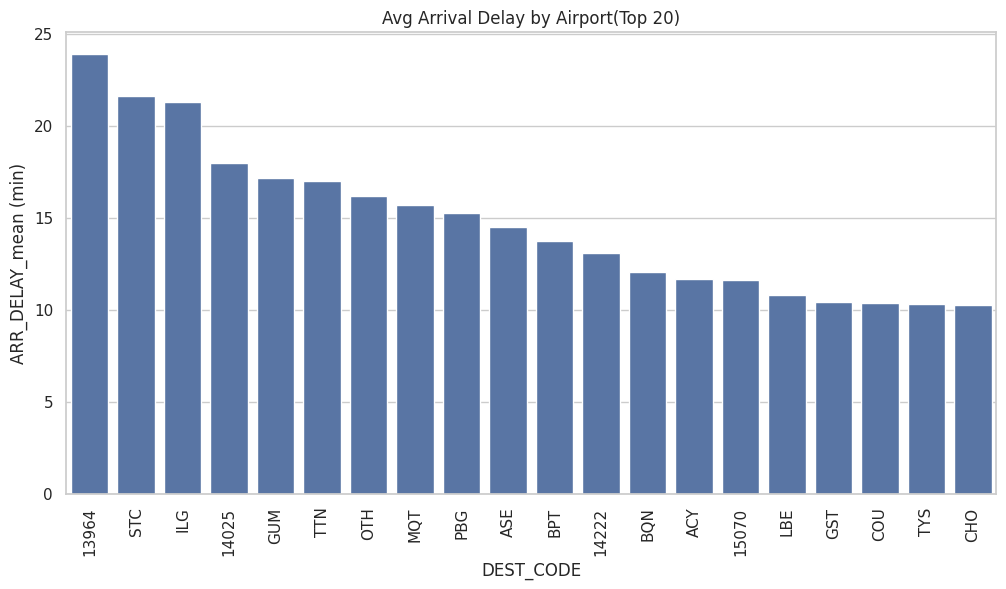

In [25]:
# -- Avg Arrival Delay by Airport
df_agg = (
    df.group_by("DEST_CODE")
      .agg(pl.col("ARR_DELAY").mean().alias("ARR_DELAY_mean (min)"))
)

# Pick the top 20 airports by highest average arrival delay
top20 = (
    df_agg.sort("ARR_DELAY_mean (min)", descending=True)
          .head(20)
          .get_column("DEST_CODE")
)

# Keep only those top 20 and convert the small frame to pandas
pdf = (
    df_agg.filter(pl.col("DEST_CODE").is_in(top20))
          .sort("ARR_DELAY_mean (min)", descending=True)
          .to_pandas()
)

plt.figure(figsize=(12,6))
sns.barplot(data=pdf, x="DEST_CODE", y="ARR_DELAY_mean (min)")
plt.xticks(rotation=90)
plt.title("Avg Arrival Delay by Airport(Top 20)")
plt.show()


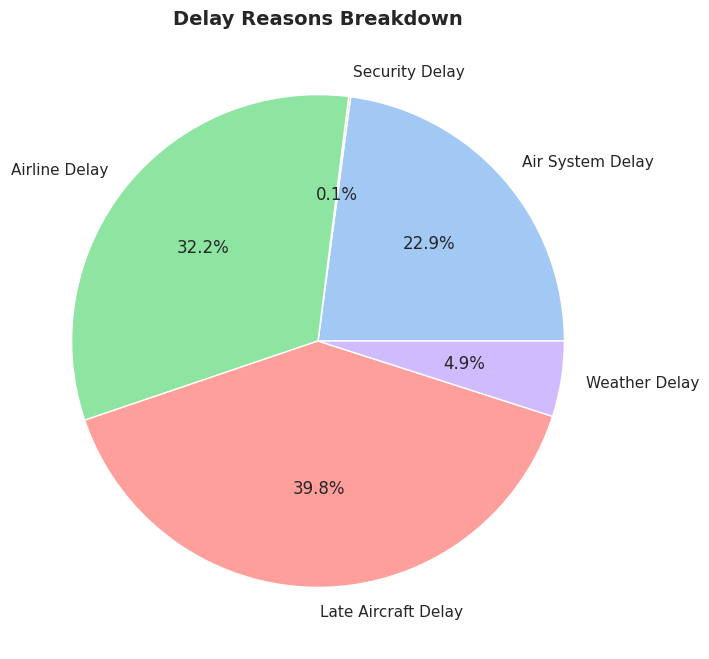

In [26]:
delay_reasons = df.select([
    pl.col("AIR_SYS_DELAY").sum().alias("Air System Delay"),
    pl.col("SEC_DELAY").sum().alias("Security Delay"),
    pl.col("AIRLINE_DELAY").sum().alias("Airline Delay"),
    pl.col("LATE_AC_DELAY").sum().alias("Late Aircraft Delay"),
    pl.col("WEATHER_DELAY").sum().alias("Weather Delay")
])

colors = sns.color_palette("pastel")

plt.figure(figsize=(8,8))
delay_reasons_pd = delay_reasons.to_pandas().T.reset_index()
delay_reasons_pd.columns = ["Reason", "Minutes"]

plt.pie(delay_reasons_pd["Minutes"], labels=delay_reasons_pd["Reason"],colors=colors, autopct='%1.1f%%')
plt.title("Delay Reasons Breakdown", fontsize=14, weight="bold")
plt.show()


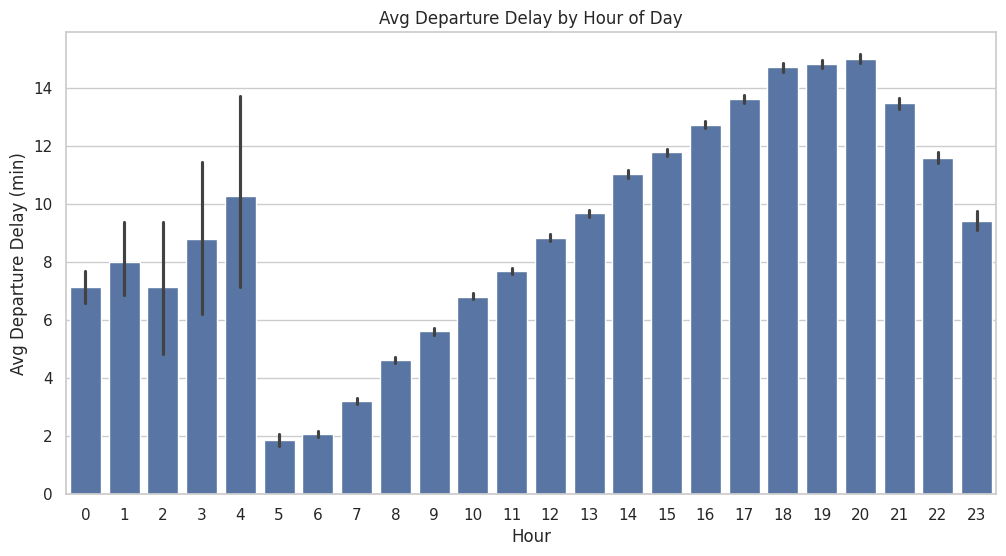

In [27]:
# -- Avg Departure Delay by Time of Day -
plt.figure(figsize=(12,6))
sns.barplot(data=df.to_pandas(), x=df.to_pandas()["SCHED_DEP_TIME"].dt.hour, y="DEP_DELAY", estimator="mean")
plt.title("Avg Departure Delay by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Avg Departure Delay (min)")
plt.show()


### 5. MISC

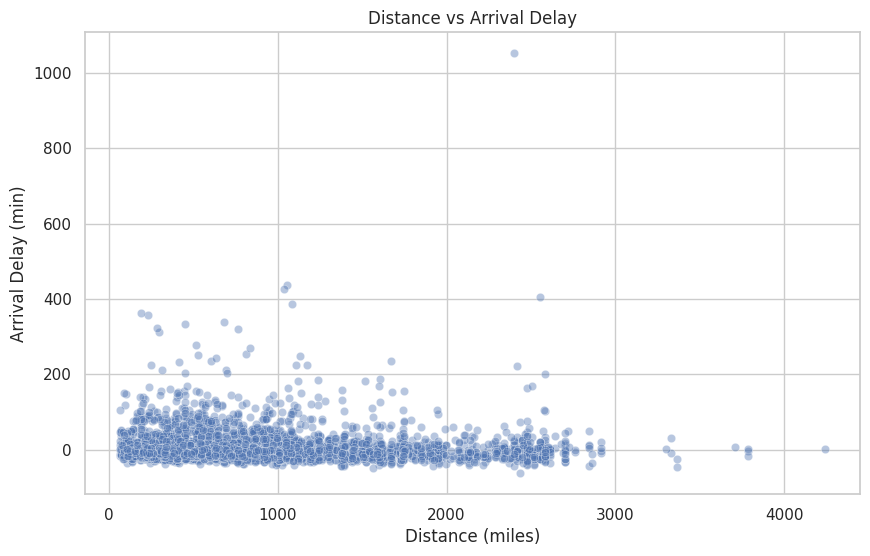

In [28]:
# -- Correlation Between Distance and Arrival Delay--
plt.figure(figsize=(10,6))
sns.scatterplot(data=df.to_pandas().sample(5000), x="DISTANCE", y="ARR_DELAY", alpha=0.4)
plt.title("Distance vs Arrival Delay")
plt.xlabel("Distance (miles)")
plt.ylabel("Arrival Delay (min)")
plt.show()


In [29]:
# --Diverted Flights % -- 
diverted = (
    df.select([
        pl.col("DIVERTED").sum().alias("Diverted Flights"),
        pl.count("FLIGHT_NUM").alias("Total Flights")
    ])
    .with_columns((pl.col("Diverted Flights") / pl.col("Total Flights") * 100).alias("Diverted %"))
)

diverted


Diverted Flights,Total Flights,Diverted %
u32,u32,f64
15187,5819079,0.260986
